<a href="https://colab.research.google.com/github/EshaAmjad26/OpenAI_SDK_Project/blob/main/context_openai_agents_sdk_and_Class_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install openai-agents SDK

In [ ]:
!pip install -Uq openai-agents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


# Make your Notebook capable of running asynchronous functions.
Both Jupyter notebooks and Python’s asyncio library utilize event loops, but they serve different purposes and can sometimes interfere with each other.

The nest_asyncio library allows the existing event loop to accept nested event loops, enabling asyncio code to run within environments that already have an event loop, such as Jupyter notebooks.

In summary, both Jupyter notebooks and Python’s asyncio library utilize event loops to manage asynchronous operations. When working within Jupyter notebooks, it’s essential to be aware of the existing event loop to effectively run asyncio code without conflicts.

In [ ]:
import nest_asyncio
nest_asyncio.apply()

# Config

In [ ]:
from pydantic import BaseModel
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel,
    RunConfig
)
from google.colab import userdata


In [ ]:
gemini_api_key = userdata.get("GEMINI_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [ ]:
# from agents import set_default_openai_client, set_tracing_disabled
# set_default_openai_client(external_client)
# set_tracing_disabled(True)

# Context Management


Context available locally to your code: this is data and dependencies you might need when tool functions run, during callbacks like on_handoff, in lifecycle hooks, etc.
- You create any Python object you want. A common pattern is to use a dataclass or a Pydantic object.
- You pass that object to the various run methods (e.g. Runner.run(..., **context=whatever**)).
- All your tool calls, lifecycle hooks etc will be passed a wrapper object, - RunContextWrapper[T], where T represents your context object type which you can access via wrapper.context.
- The most important thing to be aware of: every agent, tool function, lifecycle etc for a given agent run must use the same type of context.

You can use the context for things like:
- Contextual data for your run (e.g. things like a username/uid or other information about the user)
- Dependencies (e.g. logger objects, data fetchers, etc)
- Helper functions

[Learning Reference](https://openai.github.io/openai-agents-python/context/)

# Local Context and Dynamic Function

In [ ]:
import asyncio
from dataclasses import dataclass

from agents import Agent, RunContextWrapper, Runner, function_tool

@dataclass
class UserInfo1:
    name: str
    uid: int
    location: str = "Pakistan"
    contact_number: str = "0300-0000000"

@function_tool
async def fetch_user_age(wrapper: RunContextWrapper[UserInfo1]) -> str:
    '''Returns the age of the user.'''
    return f"User {wrapper.context.name} is 30 years old"

@function_tool
async def fetch_user_location(wrapper: RunContextWrapper[UserInfo1]) -> str:
    '''Returns the location of the user.'''
    return f"User {wrapper.context.name} is from {wrapper.context.location}"

def dynamic_instruction(wrapper: RunContextWrapper[UserInfo1], agent : Agent[UserInfo1]) -> str:
  '''Returns the contact number of the user.'''
  return f"User {wrapper.context.name} Contact Number: {wrapper.context.contact_number}"

async def main():
    user_info = UserInfo1(name="Muhammad Qasim", uid=123)

    agent = Agent[UserInfo1](
        name="Assistant",
        tools=[fetch_user_age,fetch_user_location,],
        instructions =dynamic_instruction,
        model=model
    )

    result = await Runner.run(
        starting_agent=agent,
        input="What is the age of the user? current location of his/her? and what is the contact number of user",
        context=user_info,
    )

    print(result.final_output)
    # The user John is 47 years old.

if __name__ == "__main__":
    asyncio.run(main())

The age of user Muhammad Qasim is 30 years old. The current location of user Muhammad Qasim is Pakistan and the contact number of the user is 0300-0000000.



# Agent/LLM context

In [ ]:
# from agents import enable_verbose_stdout_logging

# enable_verbose_stdout_logging()

In [ ]:
import asyncio
from dataclasses import dataclass

from agents import Agent, RunContextWrapper, Runner, function_tool

@dataclass
class UserInfo:
    name: str
    uid: int

@function_tool
async def greet_user(context: RunContextWrapper[UserInfo], greeting: str) -> str:
  """Greets the User with their name.
  Args:
    greeting: A specialed greeting message for user
  """
  name = context.context.name
  return f"Hello {name}, {greeting}"

async def main():
    user_info = UserInfo(name="Muhammad Qasim", uid=123)

    agent = Agent[UserInfo](
        name="Assistant",
        tools=[greet_user],
        model=model,
        # Dynamic function context pass in instructions/system prompmt/developer prompt
        instructions="Always greet the user using <function_call>greet_user</function_call> and welcome them to Panaversity"
    )

    result = await Runner.run(
        starting_agent=agent,
        input="Hello",
        context=user_info,
    )

    print(result.final_output)

asyncio.run(main())

Hello Muhammad Qasim, Welcome to Panaversity!



In [ ]:
import asyncio
from dataclasses import dataclass

from agents import Agent, RunContextWrapper, Runner, function_tool

@dataclass
class UserInfo:
    name: str
    uid: int

@function_tool
async def greet_user(context: RunContextWrapper[UserInfo], greeting: str) -> str:
  """Greets the User with their name.
  Args:
    greeting: A specialed greeting message for user
  """
  name = context.context.name
  return f"Hello {name}, {greeting}"

async def main():
    user_info = UserInfo(name="Junaid", uid=123)

    agent = Agent[UserInfo](
        name="Assistant",
        tools=[greet_user],
        model=model,
        instructions="Always greet the user using <function_call>greet_user</function_call> and welcome them to Panaversity"
    )

    result = await Runner.run(
        starting_agent=agent,
        input="Hello",
        context=user_info,
    )

    print(result.final_output)

asyncio.run(main())

Hello Junaid, Welcome to Panaversity!



# Class Assignment


In [ ]:
import asyncio
from agents import Agent, handoff, Runner, RunContextWrapper
from agents.tool import function_tool
from pydantic import BaseModel

In [ ]:

class ABC(BaseModel):
   User_ID : str
   User_name: str

In [ ]:
def dynamic_instructions(wrapper: RunContextWrapper[ABC], agent: Agent):
    context = wrapper.context or ABC(User_ID="01", User_name="Esha")
    return f"""
You are a smart router. Given a user query, decide whether it's best handled by one of the following domains:
- WebDev: Frontend technologies, HTML, CSS, JavaScript, responsive design, UI/UX
- Mobile_Dev: Android, iOS, React Native, Flutter, push notifications, native apps
- Agentic_AI: GPT, OpenAI, CI/CD, DevOps, cloud deployments, Kubernetes
If none match, Say Sorry.

User ID: {context.User_ID}, Name: {context.User_name}
"""



In [ ]:
DevOps = Agent(
    name='DevOps',
    instructions=(
        "You are a DevOps expert. Answer user queries related to infrastructure, CI/CD, Docker, Kubernetes, "
        "cloud deployment, or any DevOps topic.\n"
        "If the question is not related to DevOps, politely say you can only handle DevOps-related queries."
    ),
    model=model
)

OpenAiAgent = Agent(
    name='OpenAiAgent',
    instructions=(
        "You are an expert in OpenAI technologies and large language models like GPT-3 and GPT-4.\n"
        "Respond to queries about differences between models, use cases, API usage, and capabilities.\n"
        "If the question is not about OpenAI or LLMs, politely say you can only help with OpenAI-related topics."
    ),
    model=model,
)

WebDev = Agent(
    name='WebDev',
    instructions=(
        "You are a frontend web development expert. Help with HTML, CSS, JavaScript, web frameworks, responsive design, and styling.\n"
        "If the query is outside this scope, politely say you specialize only in web development topics."
    ),
    model=model,
    handoff_description="Handles frontend web dev topics like HTML, CSS, and JavaScript.",
)



Agentic_AI = Agent(
    name='Agentic_AI',
    instructions=(
        "You are an expert in intelligent AI systems, including DevOps and OpenAI tools.\n"
        "Route queries to either the DevOps agent (for infra/devops/cloud-related queries) or the OpenAiAgent (for GPT and LLM queries).\n"
        "If unsure, ask the user for clarification."
    ),
    model=model,
    tools=[
        DevOps.as_tool(
            tool_name='DevOps',
            tool_description="Handle queries related to DevOps, Kubernetes, CI/CD, etc."
        ),
        OpenAiAgent.as_tool(
            tool_name='OpenAiAgent',
            tool_description="Handle queries related to OpenAI and GPT technologies."
        )
    ],
    handoffs= [WebDev]
)

Mobile_Dev = Agent(
    name='Mobile_Dev',
    instructions=(
        "You are a mobile development expert. Always use the `get_MobileDev_info` tool to respond.\n"
        "Handle questions related to Android, iOS, React Native, mobile notifications, and native apps.\n"
        "If the query is unrelated, politely respond that you only specialize in mobile development."
    ),
    model=model,
    handoff_description="Handles mobile app queries, including React Native, push notifications, etc.",
    handoffs= [Agentic_AI] # <-
)

def Web_dev_handoff(ctx: RunContextWrapper[None]):
  print("\n\n\nHandsOff to Web Dev Agent")

def Mobile_dev_handoff(ctx: RunContextWrapper[None]):
  print("\n\n\nHandsOff to Web Dev Agent")

def Agentic_AI_handoff(ctx: RunContextWrapper[None]):
  print("\n\n\nHandsOff to Web Dev Agent")
PanaCloud = Agent(
    name='PanaCloud',
    instructions=dynamic_instructions,
    model=model,
    handoffs=[
        handoff(WebDev, on_handoff = Web_dev_handoff,),
        handoff(Mobile_Dev, on_handoff = Mobile_dev_handoff,),
        handoff(Agentic_AI, on_handoff = Agentic_AI_handoff,),
    ]
)


In [ ]:
async def main():
  msg1 = "What’s the best way to handle push notifications in a mobile app?" # → Mobile_Dev
  msg2 = "What are the differences between GPT-3 and GPT-4?"             # → Agentic_AI → OpenAiAgent
  msg3 = "How do I deploy a containerized app using Kubernetes?"     # → Agentic_AI → DevOps
  msg4 = "I need help styling a webpage using CSS."                 # → WebDev
  result =  await Runner.run(PanaCloud, msg1)
  last_agent = result.last_agent
  print(f"\n\nLast agent called: {last_agent.name}")

  print(f"\n\nFinal response:\n{result.final_output}")

In [ ]:
if __name__ == "__main__":
  asyncio.run(main())




HandsOff to Web Dev Agent




Last agent called: Mobile_Dev


Final response:
To give you the best advice on handling push notifications, I need a little more information. Could you tell me:

*   **Which platform(s) are you targeting?** (Android, iOS, React Native, or a combination?)
*   **Are you building a native app or using a cross-platform framework?**
*   **What kind of notifications are you planning to send?** (e.g., transactional, promotional, informational)

In the meantime, here are some general best practices for handling push notifications:

*   **Get explicit user consent:** Always ask users for permission before sending them push notifications.
*   **Provide clear opt-out options:** Make it easy for users to unsubscribe from notifications.
*   **Segment your audience:** Send targeted notifications to specific user groups based on their interests and behavior.
*   **Personalize your messages:** Use user data to create personalized and relevant notifications.
*   **Time your notifications carefully:**

In [ ]:
!pip install -qU "openai_agents[viz]"

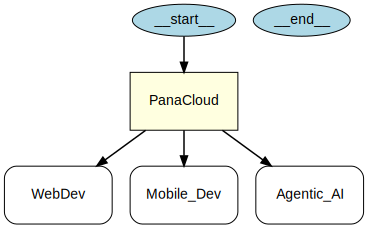

In [ ]:
from agents.extensions.visualization import draw_graph
draw_graph(PanaCloud)

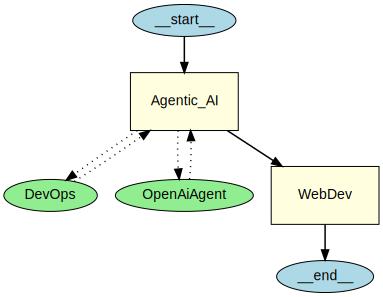

In [ ]:
draw_graph(Agentic_AI)

# NOW Check behaviour with RAG

In [ ]:

@function_tool("tavily_search")
def tavily_search():
    """Search the URL and return the raw content extracted from the page."""
    print("[DEBUG] Searching the Docs...")
    tavily_client = TavilyClient(api_key="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")
    try:
        response = tavily_client.extract("https://openai.github.io/openai-agents-python/")

        print("\n[DEBUG] Raw Response:\n", response)  # Log full response for inspection

        results = response.get("results", [])
        if not results:
            return "No content found in the search results."

        # Extract and join raw_content
        contents = [item.get("raw_content", "No raw content found") for item in results]
        return "\n\n".join(contents)

    except Exception as e:
        print(f"[ERROR] An error occurred while searching: {e}")
        return f"An error occurred: {str(e)}"


def dynamic_instructions(wrapper: RunContextWrapper[ABC], agent: Agent):
    context = wrapper.context or ABC(User_ID="01", User_name="Esha")
    return f"""
You are a smart router. Given a user query, decide whether it's best handled by one of the following domains:
- WebDev: Frontend technologies, HTML, CSS, JavaScript, responsive design, UI/UX
- Mobile_Dev: Android, iOS, React Native, Flutter, push notifications, native apps
- Agentic_AI: GPT, OpenAI, CI/CD, DevOps, cloud deployments, Kubernetes
If none match, Say Sorry.

User ID: {context.User_ID}, Name: {context.User_name}
"""



DevOps = Agent(
    name='DevOps',
    instructions=(
        "You are a DevOps expert. Answer user queries related to infrastructure, CI/CD, Docker, Kubernetes, "
        "cloud deployment, or any DevOps topic.\n"
        "If the question is not related to DevOps, politely say you can only handle DevOps-related queries."
    ),
    model=model
)

OpenAiAgent = Agent(
    name='OpenAiAgent',
    instructions=(
        "You are an expert in OpenAI technologies and large language models like GPT-3 and GPT-4.\n"
        "Respond to queries about differences between models, use cases, API usage, and capabilities.\n"
        "If the question is not about OpenAI or LLMs, politely say you can only help with OpenAI-related topics."
    ),
    model=model,

)

WebDev = Agent(
    name='WebDev',
    instructions=(
        "You are a frontend web development expert. Help with HTML, CSS, JavaScript, web frameworks, responsive design, and styling.\n"
        "If the query is outside this scope, politely say you specialize only in web development topics."
    ),
    model=model,
    handoff_description="Handles frontend web dev topics like HTML, CSS, and JavaScript.",
)



Agentic_AI = Agent(
    name='Agentic_AI',
    instructions=(
        "You are an expert in intelligent AI systems, including DevOps and OpenAI tools.\n"
        "Route queries to either the DevOps agent (for infra/devops/cloud-related queries) or the OpenAiAgent (for GPT and LLM queries).\n"
        "If unsure, ask the user for clarification."
    ),
    model=model,
    tools=[
        DevOps.as_tool(
            tool_name='DevOps',
            tool_description="Handle queries related to DevOps, Kubernetes, CI/CD, etc."
        ),
        OpenAiAgent.as_tool(
            tool_name='OpenAiAgent',
            tool_description="Handle queries related to OpenAI and GPT technologies."
        )
    ],
    handoffs= [WebDev]
)

Mobile_Dev = Agent(
    name='Mobile_Dev',
    instructions=(
        "You are a mobile development expert. Always use the `get_MobileDev_info` tool to respond.\n"
        "Handle questions related to Android, iOS, React Native, mobile notifications, and native apps.\n"
        "If the query is unrelated, politely respond that you only specialize in mobile development."
    ),
    model=model,
    handoff_description="Handles mobile app queries, including React Native, push notifications, etc.",
    handoffs= [Agentic_AI] # <-
)

def Web_dev_handoff(ctx: RunContextWrapper[None]):
  print("\n\n\nHandsOff to Web Dev Agent")

def Mobile_dev_handoff(ctx: RunContextWrapper[None]):
  print("\n\n\nHandsOff to Web Dev Agent")

def Agentic_AI_handoff(ctx: RunContextWrapper[None]):
  print("\n\n\nHandsOff to Web Dev Agent")
PanaCloud = Agent(
    name='PanaCloud',
    instructions=dynamic_instructions,
    model=model,
    handoffs=[
        handoff(WebDev, on_handoff = Web_dev_handoff,),
        handoff(Mobile_Dev, on_handoff = Mobile_dev_handoff,),
        handoff(Agentic_AI, on_handoff = Agentic_AI_handoff,),
    ],
    tools=[tavily_search]
)

async def main():
  msg1 = "What’s the best way to handle push notifications in a mobile app?" # → Mobile_Dev
  msg2 = "What are the differences between GPT-3 and GPT-4?"             # → Agentic_AI → OpenAiAgent
  msg3 = "How do I deploy a containerized app using Kubernetes?"     # → Agentic_AI → DevOps
  msg4 = "I need help styling a webpage using CSS."                 # → WebDev
  result =  await Runner.run(PanaCloud, "What is Open AI Agent SDK")
  last_agent = result.last_agent
  print(f"\n\nLast agent called: {last_agent.name}")

  print(f"\n\nFinal response:\n{result.final_output}")


if __name__ == "__main__":
    asyncio.run(main())




HandsOff to Web Dev Agent


Last agent called: Agentic_AI


Final response:
To clarify, are you asking about the OpenAI Agent SDK, or more generally about agent SDKs that can be used with OpenAI models?



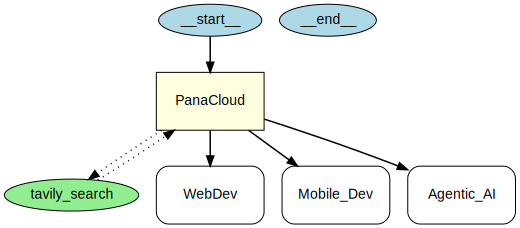

In [ ]:
draw_graph(PanaCloud)